# ライブラリーのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

# データのインポート

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape, test.shape)

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 欠損値の確認

In [6]:
total = train.isnull().sum().sort_values(ascending=False)
precent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, precent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] >0]
missing_data

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


欠損地の割合が全体の80%以上に及ぶ特長量は列削除、全体の3%未満の特徴量は行削除

In [7]:
drop_cols = missing_data[missing_data['Percent'] > 80].index.tolist()
drop_rows = missing_data[missing_data['Percent'] < 3].index.tolist()

print(drop_cols)
print(drop_rows)

train = train.drop(columns=drop_cols)
train.dropna(inplace=True, subset=drop_rows)

['PoolQC', 'MiscFeature', 'Alley', 'Fence']
['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrArea', 'MasVnrType', 'Electrical']


In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


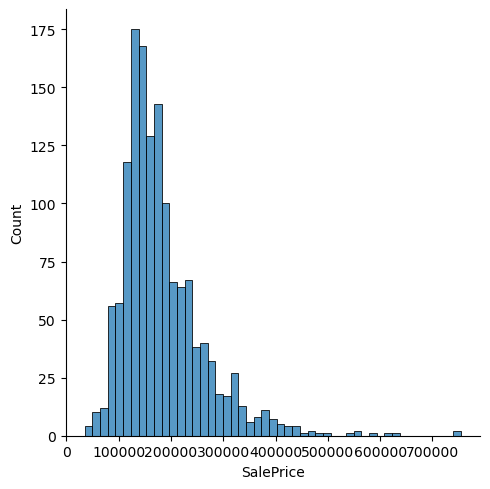

In [9]:
sns.displot(train['SalePrice'])

testにも列のみ同様の処理を行う(行は提出に必要なため削除できない)

In [10]:
test = test.drop(columns=drop_cols)
test.head()

In [12]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [14]:
# 再分割
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

# テスト用と検証用にデータを分割

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# モデルの構築と訓練

In [16]:
reg = XGBRegressor(n_estimators=1000, learing_rate=0.05)
reg.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)])

[20:45:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "learing_rate" } are not used.

[0]	validation_0-rmse:152798.38920
[1]	validation_0-rmse:112175.21400
[2]	validation_0-rmse:84798.93704
[3]	validation_0-rmse:67374.84361
[4]	validation_0-rmse:55828.74998
[5]	validation_0-rmse:48811.38981
[6]	validation_0-rmse:44925.83036
[7]	validation_0-rmse:42820.72430
[8]	validation_0-rmse:41998.21164
[9]	validation_0-rmse:41859.92292
[10]	validation_0-rmse:41741.86492
[11]	validation_0-rmse:41525.14987
[12]	validation_0-rmse:41702.77567
[13]	validation_0-rmse:41647.97483
[14]	validation_0-rmse:41558.67997
[15]	validation_0-rmse:41481.64601
[16]	validation_0-rmse:41541.64758
[17]	validation_0-rmse:41612.23052
[18]	validation_0-rmse:41503.76112
[19]	validation_0-rmse:41346.03595
[20]	validation_0-rmse:41425.17258
[21]	validation_0-rmse:41431.36296
[22]	validation_0-rmse:41451.78033
[23]	validation_0-rmse:41494.05527


/Users/kawamurakentarou/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:41512.30037


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learing_rate=0.05,
             learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

# 結果の予測と提出

In [17]:
y_pred = reg.predict(X_test)

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': y_pred})
submission.to_csv('submission.csv', index=False)

In [18]:
submission.head()

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64